In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import os
from pathlib import Path
from enum import Enum
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ELU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing import image

In [4]:
PHASES = ['train', 'val', 'test']
DIAGNOSIS = ['0_normal', '1_ulcerative_colitis', '2_polyps', '3_esophagitis']    
DIR = Path('.')

In [5]:
os.listdir('./train')

['3_esophagitis', '1_ulcerative_colitis', '0_normal', '2_polyps']

In [6]:
import os

def count_images_in_directory(base_dir):
    """Counts the number of images in each class directory within the base directory."""
    class_counts = {}
    
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            image_count = len([f for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
            class_counts[class_name] = image_count
            
    return class_counts

# Define the base directories for train, validation, and test
train_dir = './train'
validation_dir = './val'
test_dir = './test'

# Count images in each directory
train_counts = count_images_in_directory(train_dir)
validation_counts = count_images_in_directory(validation_dir)
test_counts = count_images_in_directory(test_dir)

print("Training set image counts per class:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nValidation set image counts per class:")
for class_name, count in validation_counts.items():
    print(f"{class_name}: {count} images")

print("\nTest set image counts per class:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")


Training set image counts per class:
3_esophagitis: 800 images
1_ulcerative_colitis: 800 images
0_normal: 800 images
2_polyps: 800 images

Validation set image counts per class:
3_esophagitis: 500 images
1_ulcerative_colitis: 500 images
0_normal: 500 images
2_polyps: 500 images

Test set image counts per class:
3_esophagitis: 200 images
1_ulcerative_colitis: 200 images
0_normal: 200 images
2_polyps: 200 images


In [7]:
# Collecting the images paths

# Initialize an empty DataFrame
df = pd.DataFrame(columns=['phase', 'diagnosis', 'path'])

data = []

for phase in PHASES:
    for diagnosis in DIAGNOSIS:
        # Construct the search pattern
        search_pattern = str(DIR / phase / diagnosis / '*')
        
        # Get all file paths that match the pattern
        paths = glob.glob(search_pattern)
        
        # Add entries to the data list
        for path in paths:
            data.append({'phase': phase, 'diagnosis': diagnosis, 'path': path})

# Convert the data list to a DataFrame
df = pd.DataFrame(data)


In [8]:
df.head()

,phase,diagnosis,path
0,train,0_normal,train/0_normal/train_normal_ (222).jpg
1,train,0_normal,train/0_normal/train_normal_ (566).jpg
2,train,0_normal,train/0_normal/train_normal_ (613).jpg
3,train,0_normal,train/0_normal/train_normal_ (780).jpg
4,train,0_normal,train/0_normal/train_normal_ (622).jpg


In [9]:
## add image shape info
df['height'] = 0
df['width'] = 0
df

,phase,diagnosis,path,height,width
0,train,0_normal,train/0_normal/train_normal_ (222).jpg,0,0
1,train,0_normal,train/0_normal/train_normal_ (566).jpg,0,0
2,train,0_normal,train/0_normal/train_normal_ (613).jpg,0,0
3,train,0_normal,train/0_normal/train_normal_ (780).jpg,0,0
4,train,0_normal,train/0_normal/train_normal_ (622).jpg,0,0
...,...,...,...,...,...
5995,test,3_esophagitis,test/3_esophagitis/test_esophagitis_ (45).jpg,0,0
5996,test,3_esophagitis,test/3_esophagitis/test_esophagitis_ (105).jpg,0,0
5997,test,3_esophagitis,test/3_esophagitis/test_esophagitis_ (108).jpg,0,0
5998,test,3_esophagitis,test/3_esophagitis/test_esophagitis_ (198).jpg,0,0


In [10]:
def read_image(row):
    image = cv2.imread(row['path'])
    height, width, ch = image.shape
    return pd.Series([height, width])

df[['height','width']] = df.apply(read_image, axis=1)


In [11]:
df.head()

,phase,diagnosis,path,height,width
0,train,0_normal,train/0_normal/train_normal_ (222).jpg,532,633
1,train,0_normal,train/0_normal/train_normal_ (566).jpg,576,720
2,train,0_normal,train/0_normal/train_normal_ (613).jpg,576,720
3,train,0_normal,train/0_normal/train_normal_ (780).jpg,576,720
4,train,0_normal,train/0_normal/train_normal_ (622).jpg,576,720


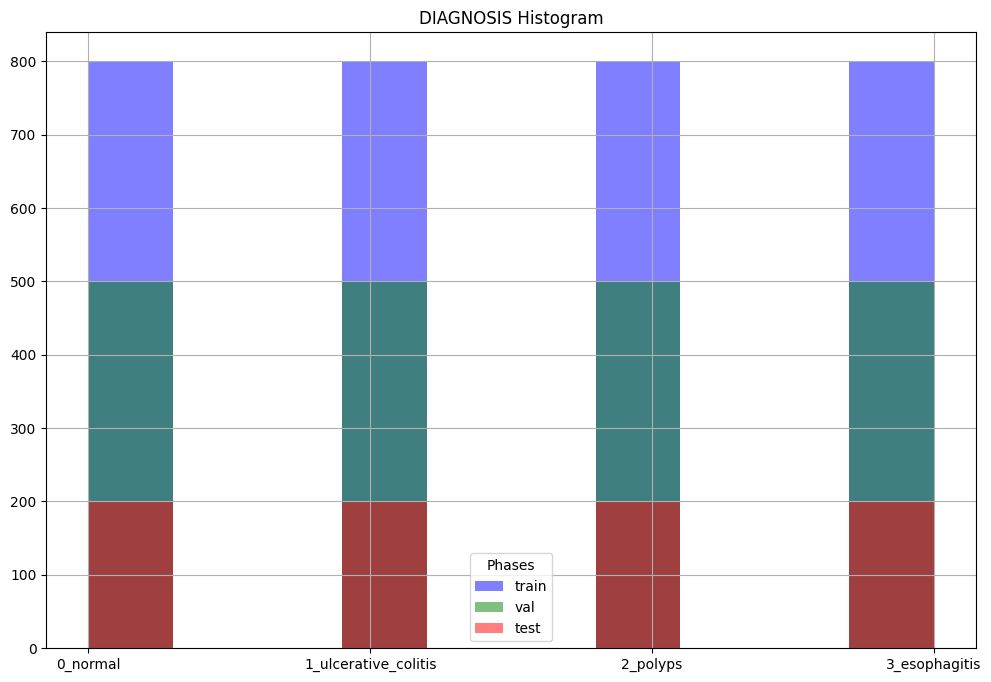

In [12]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

plt.title('DIAGNOSIS Histogram')

# Create a color map for different phases
colors = ['blue', 'green', 'red']  # Example colors, adjust as needed

# Loop through each phase and plot the histogram with specific colors
for phase, color in zip(PHASES, colors):
    subset = df[df['phase'] == phase]
    subset['diagnosis'].hist(color=color, alpha=0.5, label=phase)

# Add legend to the plot
plt.legend(title='Phases')

# Show the plot
plt.show()


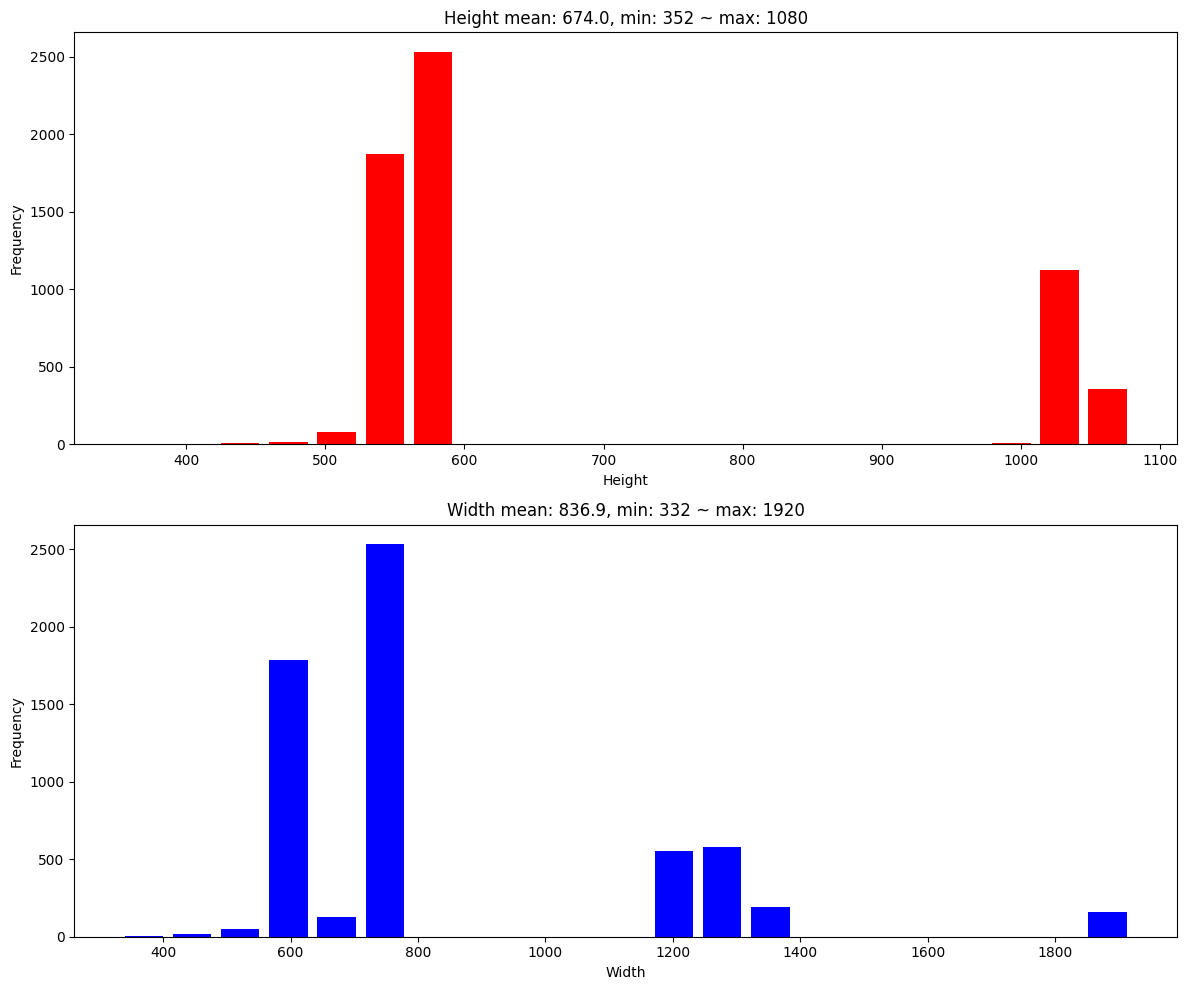

In [13]:
# Helper function to plot a histogram
def plot_histogram(ax, data, column_name, color, bins=21):
    """Plots a histogram on the given axis."""
    ax.hist(data, bins=bins, rwidth=0.8, color=color)
    mean_val = data.mean()
    min_val = data.min()
    max_val = data.max()
    ax.set_title(f"{column_name} mean: {mean_val:.1f}, min: {min_val} ~ max: {max_val}")
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')

# Create a figure with a specified size
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot histogram for 'height'
plot_histogram(axs[0], df['height'], 'Height', color='red')

# Plot histogram for 'width'
plot_histogram(axs[1], df['width'], 'Width', color='blue')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

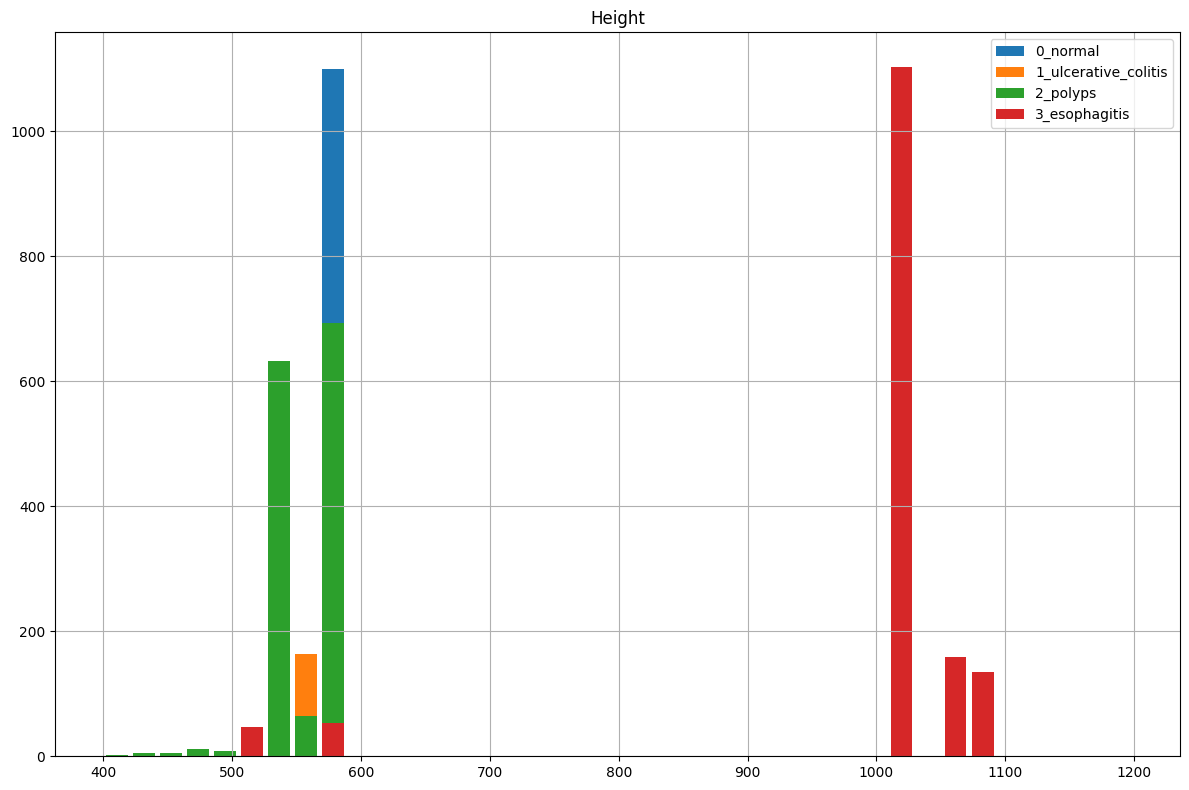

In [14]:
plt.figure(figsize=[12, 8])
plt.title('Height')
for diagnosis in DIAGNOSIS:
    temp_df = df[df['diagnosis']==diagnosis]
    temp_df['height'].hist(bins=np.arange(400, 1200, 21), rwidth=.8)        
plt.legend(DIAGNOSIS)
plt.tight_layout()

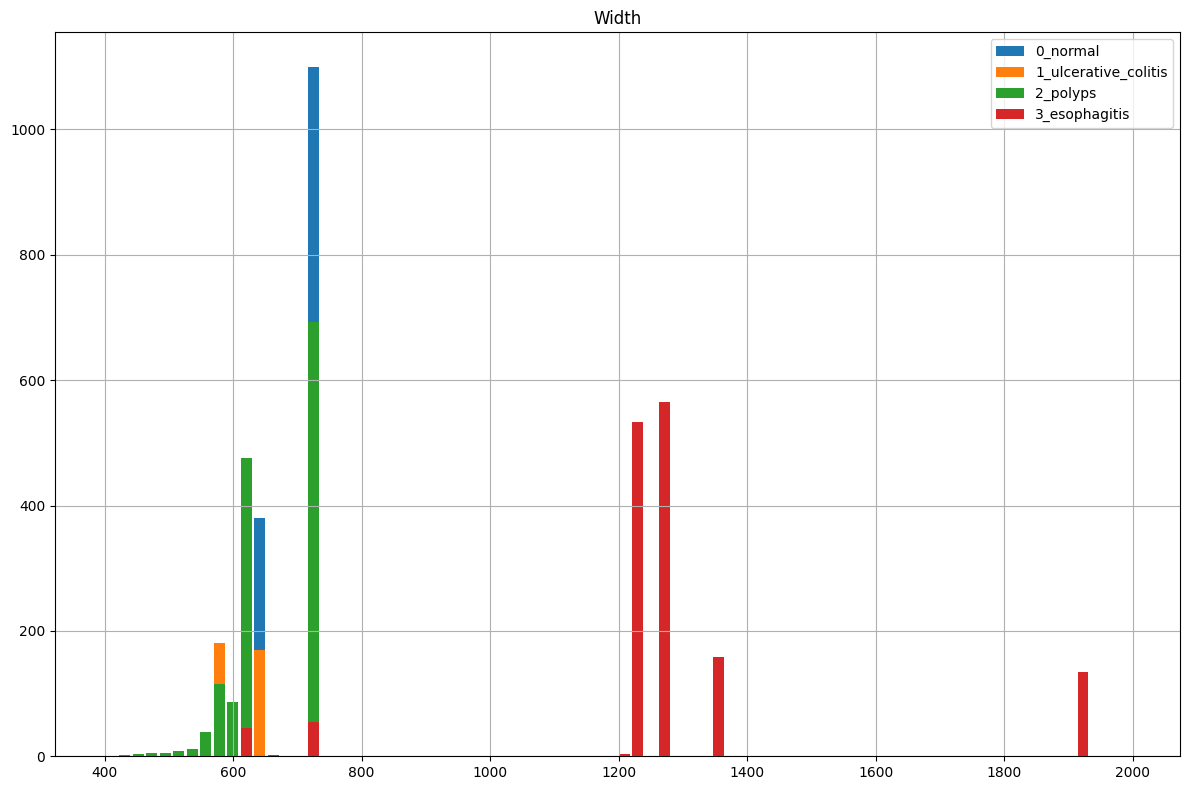

In [15]:
plt.figure(figsize=[12, 8])
plt.title('Width')
for diagnosis in DIAGNOSIS:
    temp_df = df[df['diagnosis']==diagnosis]
    temp_df['width'].hist(bins=np.arange(400, 2000, 21), rwidth=.8)        
plt.legend(DIAGNOSIS)
plt.tight_layout()


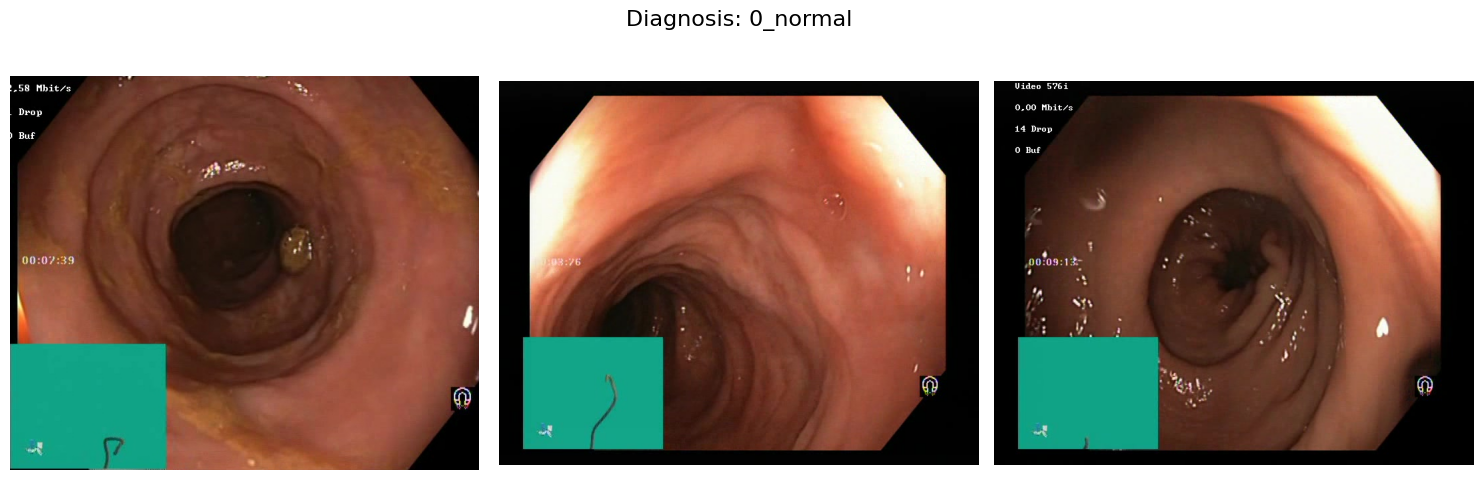

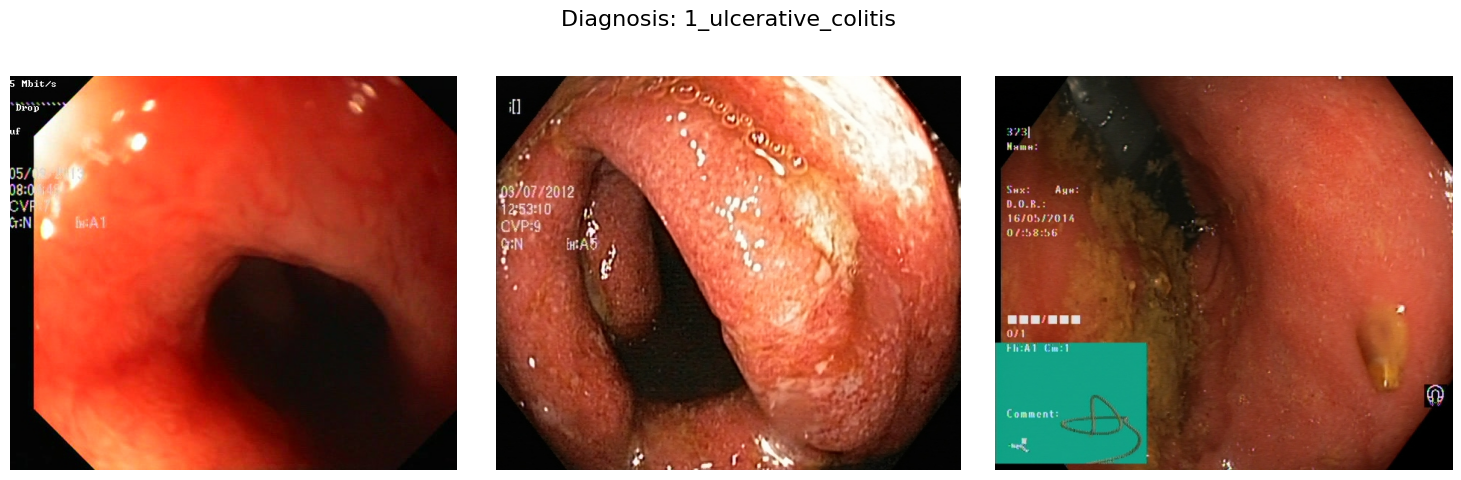

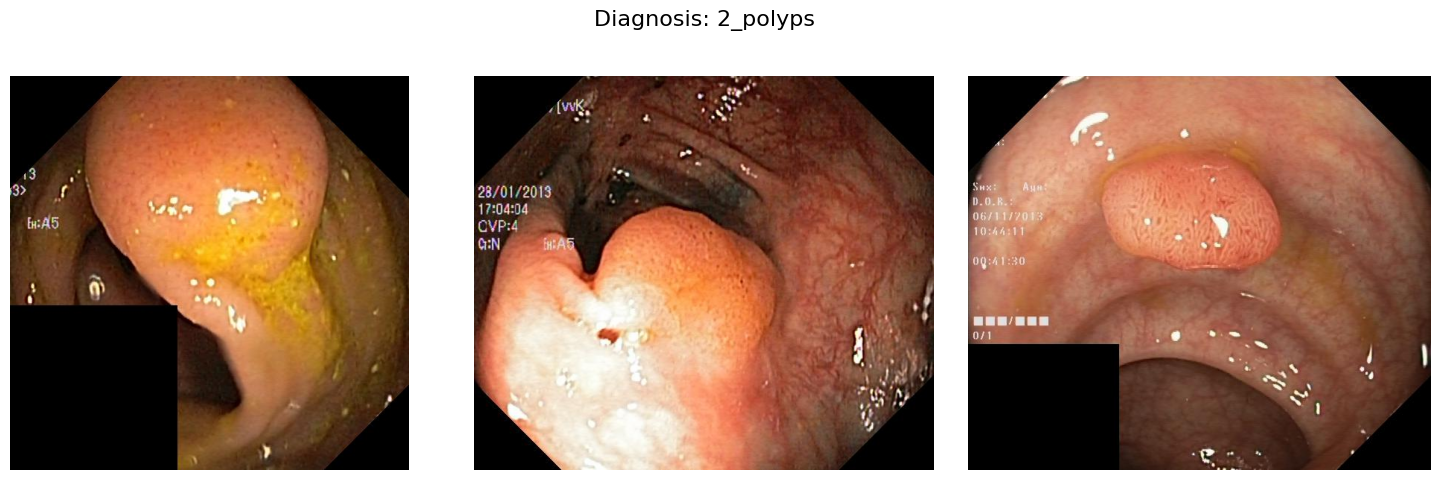

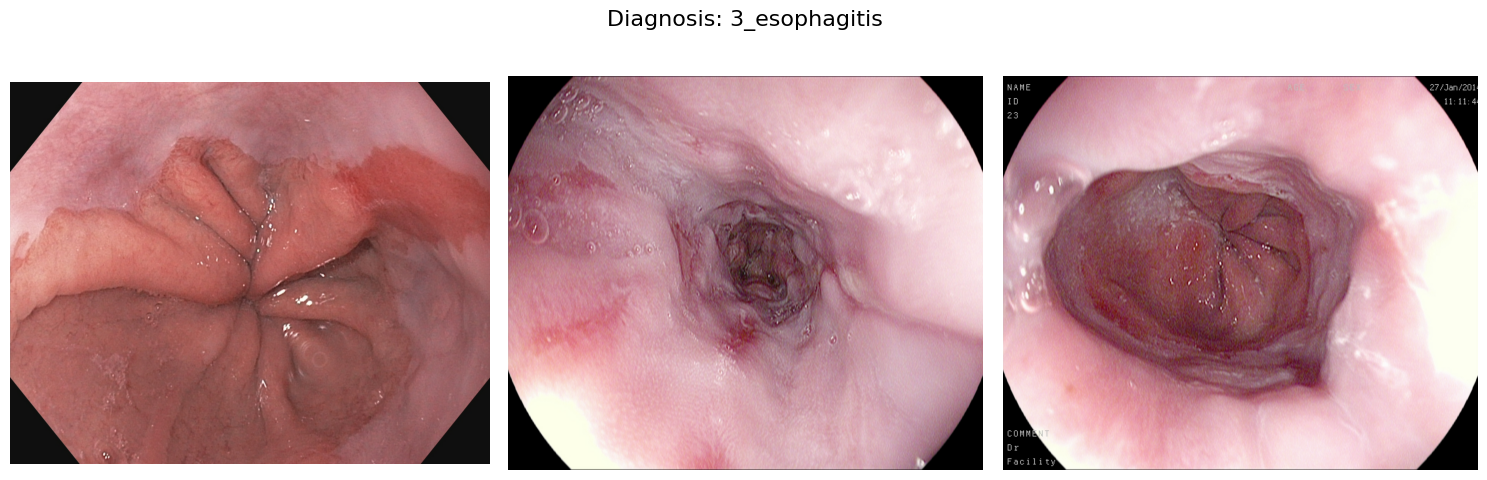

In [16]:
import matplotlib.pyplot as plt
import cv2

# Loop through each diagnosis category
for diagnosis in DIAGNOSIS:
    # Filter the DataFrame for the current diagnosis in the 'train' phase and select the first 3 entries
    temp_df = df[(df['phase'] == 'train') & (df['diagnosis'] == diagnosis)].head(3)
    
    # Create a new figure with a specified size
    plt.figure(figsize=(15, 5))
    
    # Set the main title of the figure
    plt.suptitle(f'Diagnosis: {diagnosis}', fontsize=16)
    
    # Loop through each of the first 3 images
    for n in range(len(temp_df)):
        # Read the image from the file path
        img_path = temp_df.iloc[n].path
        img = cv2.imread(img_path)
        
        # Convert the image from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create a subplot for the current image
        plt.subplot(1, 3, n + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axis for better visualization
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the figure
    plt.show()